In [1]:
!nvidia-smi

Thu Sep 16 17:13:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler

from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import Counter
import torchvision.models as models
from collections import OrderedDict
torch.autograd.set_detect_anomaly(True)
import copy
import datetime
import pytz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
TRAIN_CSV_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/csv/UTKFace_1_101-all-classes.csv'
IMAGE_PATH = '/content/drive/MyDrive/CSE465/datasets/UTKFace/UTKFace-images'

RANDOM_SEED = 42
MODEL_NAME = "All-Classes-Full-UTK-CE_ResNet152-Pretrained-Finetuned-100%-EPOCHS-100-withoutLRS"
PATH = "/content/drive/MyDrive/CSE465/Models_and_Logs/" + MODEL_NAME

GRAYSCALE = False
NUM_CLASSES = 101
BATCH_SIZE = 64
EPOCHS = 100
learning_rate = 0.0005
NUM_WORKERS = 0

In [5]:
# GPU or CPU
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
# Log File
if not os.path.exists(PATH): os.mkdir(PATH)
LOGFILE = os.path.join(PATH, 'training.log')

In [7]:
header = []
timezone = pytz.timezone('Asia/Dhaka')
header.append(f'\n\n\nLast Run: {datetime.datetime.now(timezone)}')
header.append(f'PyTorch Version: {torch.__version__}')
header.append(f'CUDA device available: {torch.cuda.is_available()}')
header.append(f'Using CUDA device: {DEVICE}')
header.append(f'Random Seed: {RANDOM_SEED}')
header.append(f'NUM WORKERS: {NUM_WORKERS}')
header.append(f'Model Name: {MODEL_NAME}')
header.append(f'Output Path: {PATH}')
header.append(f'-------------------HyperParameters---------------')
header.append(f'No. of Classes: {NUM_CLASSES}')
header.append(f'Batch size: {BATCH_SIZE}')
header.append(f'Grayscale: {GRAYSCALE}')
header.append(f'Learning Rate: {learning_rate}')
header.append(f'Epochs: {EPOCHS}')

In [8]:
for entry in header:
  print(entry)




Last Run: 2021-09-16 23:14:14.505670+06:00
PyTorch Version: 1.9.0+cu102
CUDA device available: True
Using CUDA device: cuda
Random Seed: 42
NUM WORKERS: 0
Model Name: All-Classes-Full-UTK-CE_ResNet152-Pretrained-Finetuned-100%-EPOCHS-100-withoutLRS
Output Path: /content/drive/MyDrive/CSE465/Models_and_Logs/All-Classes-Full-UTK-CE_ResNet152-Pretrained-Finetuned-100%-EPOCHS-100-withoutLRS
-------------------HyperParameters---------------
No. of Classes: 101
Batch size: 64
Grayscale: False
Learning Rate: 0.0005
Epochs: 100


In [9]:
with open(LOGFILE, 'a') as f:
    for entry in header:
        f.write(f'{entry}\n')
        f.flush()

# Dataset

In [10]:
class UTKFaceDataset(Dataset):
    """Custom Dataset for loading UTKFace face images"""
    def __init__(self, csv_path, img_dir, transform=None, items=None):

        df = pd.read_csv(csv_path)
        df['index'] = range(0, len(df))
        df = df.set_index('index')
        
        if items:
          df=df[:items]
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['file'].values
        # print(type(self.img_names))
        # self.y = df['label'].values
        self.y = df['label-CE'].values
        self.age = df['age'].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir, self.img_names[index]))
        # img = img.convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]

        return img, label

    def __len__(self):
        return self.y.shape[0]

In [11]:
custom_transform_train = transforms.Compose([transforms.Resize((256, 256)),
                                       transforms.RandomCrop((224, 224)),
                                       transforms.ToTensor(),
                                       ])

train_dataset = UTKFaceDataset(csv_path=TRAIN_CSV_PATH,
                               img_dir=IMAGE_PATH,
                               transform=custom_transform_train,
                               items = None
                               )

# Dataset Entity Distribution Analysis

In [12]:
def dataset_analysis(d):
  counter_label = Counter(np.sort(d.y))
  counter_age = Counter(np.sort(d.age))

  plt.scatter(counter_age.keys(), counter_age.values(), s=10, c='black')
  plt.xlabel('Ages')
  plt.ylabel('Num of images per Age')
  plt.title('Entity Distribution Analysis')
  plt.grid()
  plt.show()
  
  print("label\t\tAge\t\tCount")
  for (label, key, value) in zip(counter_label.keys(), counter_age.keys(), counter_age.values()):
    print(label,'\t\t',key,'\t\t', value)

  print(torch.from_numpy(d.age).bincount())
  print('length of the dataset is: ', len(d))

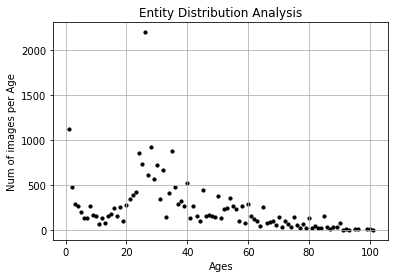

label		Age		Count
0 		 1 		 1123
1 		 2 		 482
2 		 3 		 289
3 		 4 		 273
4 		 5 		 196
5 		 6 		 131
6 		 7 		 139
7 		 8 		 263
8 		 9 		 166
9 		 10 		 156
10 		 11 		 65
11 		 12 		 130
12 		 13 		 81
13 		 14 		 157
14 		 15 		 177
15 		 16 		 247
16 		 17 		 158
17 		 18 		 262
18 		 19 		 98
19 		 20 		 284
20 		 21 		 346
21 		 22 		 395
22 		 23 		 426
23 		 24 		 859
24 		 25 		 734
25 		 26 		 2197
26 		 27 		 615
27 		 28 		 918
28 		 29 		 570
29 		 30 		 724
30 		 31 		 350
31 		 32 		 664
32 		 33 		 143
33 		 34 		 409
34 		 35 		 880
35 		 36 		 483
36 		 37 		 293
37 		 38 		 325
38 		 39 		 266
39 		 40 		 526
40 		 41 		 132
41 		 42 		 266
42 		 43 		 157
43 		 44 		 100
44 		 45 		 440
45 		 46 		 153
46 		 47 		 170
47 		 48 		 153
48 		 49 		 148
49 		 50 		 381
50 		 51 		 138
51 		 52 		 232
52 		 53 		 241
53 		 54 		 353
54 		 55 		 268
55 		 56 		 236
56 		 57 		 97
57 		 58 		 271
58 		 59 		 82
59 		 60 		 293
60 		 61 		 161
61 		 62 		 125
62 		 63 		 

In [13]:
dataset_analysis(train_dataset)

# Dataset Loader

In [14]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

In [15]:
len(train_loader)

371

# Initialise Model & Optimizer

In [16]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

model = models.resnet152(pretrained=True)

# model.fc.in_features is 512
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

params_to_update = model.parameters()
print("Params to learn:")
for name,param in model.named_parameters(): print("\t",name)

model.to(DEVICE)
optimizer = torch.optim.Adam(params_to_update, lr=learning_rate)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

`torch.max()` `returns` highest elements along the dimension and indexes of highest values, here we are only interested to the indexes of highest elements

In [18]:
def calculate_correct_preds(probas, targets):
  return torch.sum(torch.max(probas, dim = 1)[1] == targets)

In [19]:
def compute_acc(total_num_correct_preds, num_examples):
  return format((total_num_correct_preds/num_examples) * 100.0, '.3f')

# Training

PyTorch Normally add the previously calculated gradient with the current calculated gradient and then updates the weight. But here we don't want it. That's why we made the previously calculted gradient zero while calculating a new one with `optimizer.zero_grad()`

In [20]:
start_time = time.time()

for epoch in tqdm(range(EPOCHS)):
  train_total_num_correct_preds = train_num_examples = 0
 
  model.train()
  train_mae=0.0
  for batch_idx, (features, targets) in enumerate(tqdm(train_loader)):
      targets, features =  targets.to(DEVICE), features.to(DEVICE)

      # FORWARD AND BACK PROP
      logits = model(features)
      cost = F.cross_entropy(logits, targets)
      probas = F.softmax(logits, dim=1)
      _, predicted_labels = torch.max(probas, dim=1)

      optimizer.zero_grad()
      cost.backward()

      # UPDATE MODEL PARAMETERS
      optimizer.step()
      

      train_total_num_correct_preds += calculate_correct_preds(probas, targets)
      train_num_examples += targets.size(0) 
      train_mae += torch.sum(torch.abs(predicted_labels - targets))

  train_mae = train_mae/train_num_examples

  # LOGGING
  print(f'Correct Train Preds: {train_total_num_correct_preds}')
  training_acc = compute_acc(train_total_num_correct_preds, train_num_examples)

  time_elapsed = format((time.time() - start_time)/60, ".3f")
  str1 = f'Epoch: {epoch+1}/{EPOCHS} \n'
  str2 = f'--------------------------------------------------------------------\n'
  str3 = f'Training MAE: {format(train_mae, ".3f")}\n'
  str4 = f'Training_Cost: {format(cost, ".3f")}\n'
  str5 = f'Training_Acc: {training_acc}%\n'
  str6 = f'Time elapsed: {time_elapsed}mins\n'

  str = str1+str2+str3+str4+str5+str6
  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')
  
  model_name = f'Epoch_{epoch+1}_model.pt'
  torch.save(model.state_dict(), os.path.join(PATH, model_name)) # saving the model
  with open(LOGFILE, 'a') as f: f.write(f'---Model Saved---\n')
  print(f'---Model Saved---\n')
    
with open(LOGFILE, 'a') as f: f.write('\n\n############-------Training Completed-------############\n\n')
print("TRAINING COMPLETED")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/371 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Correct Train Preds: 3397
Epoch: 1/100 
--------------------------------------------------------------------
Training MAE: 8.799
Training_Cost: 3.423
Training_Acc: 14.340%
Time elapsed: 139.828mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 3888
Epoch: 2/100 
--------------------------------------------------------------------
Training MAE: 6.678
Training_Cost: 2.297
Training_Acc: 16.413%
Time elapsed: 146.372mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4164
Epoch: 3/100 
--------------------------------------------------------------------
Training MAE: 6.033
Training_Cost: 3.437
Training_Acc: 17.578%
Time elapsed: 152.877mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4382
Epoch: 4/100 
--------------------------------------------------------------------
Training MAE: 5.716
Training_Cost: 3.723
Training_Acc: 18.498%
Time elapsed: 159.462mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4482
Epoch: 5/100 
--------------------------------------------------------------------
Training MAE: 5.454
Training_Cost: 2.861
Training_Acc: 18.920%
Time elapsed: 165.983mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4583
Epoch: 6/100 
--------------------------------------------------------------------
Training MAE: 5.229
Training_Cost: 3.594
Training_Acc: 19.347%
Time elapsed: 172.483mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4770
Epoch: 7/100 
--------------------------------------------------------------------
Training MAE: 5.015
Training_Cost: 3.342
Training_Acc: 20.136%
Time elapsed: 178.995mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4822
Epoch: 8/100 
--------------------------------------------------------------------
Training MAE: 4.842
Training_Cost: 3.149
Training_Acc: 20.355%
Time elapsed: 185.518mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 4978
Epoch: 9/100 
--------------------------------------------------------------------
Training MAE: 4.692
Training_Cost: 4.723
Training_Acc: 21.014%
Time elapsed: 191.996mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5156
Epoch: 10/100 
--------------------------------------------------------------------
Training MAE: 4.577
Training_Cost: 3.458
Training_Acc: 21.765%
Time elapsed: 198.467mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5316
Epoch: 11/100 
--------------------------------------------------------------------
Training MAE: 4.355
Training_Cost: 2.649
Training_Acc: 22.441%
Time elapsed: 204.953mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5541
Epoch: 12/100 
--------------------------------------------------------------------
Training MAE: 4.215
Training_Cost: 3.336
Training_Acc: 23.391%
Time elapsed: 211.429mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 5630
Epoch: 13/100 
--------------------------------------------------------------------
Training MAE: 4.111
Training_Cost: 2.535
Training_Acc: 23.766%
Time elapsed: 217.909mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6024
Epoch: 14/100 
--------------------------------------------------------------------
Training MAE: 3.885
Training_Cost: 2.333
Training_Acc: 25.430%
Time elapsed: 224.394mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6056
Epoch: 15/100 
--------------------------------------------------------------------
Training MAE: 3.693
Training_Cost: 2.575
Training_Acc: 25.565%
Time elapsed: 230.877mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6470
Epoch: 16/100 
--------------------------------------------------------------------
Training MAE: 3.539
Training_Cost: 3.032
Training_Acc: 27.312%
Time elapsed: 237.358mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 6753
Epoch: 17/100 
--------------------------------------------------------------------
Training MAE: 3.411
Training_Cost: 4.067
Training_Acc: 28.507%
Time elapsed: 243.839mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7193
Epoch: 18/100 
--------------------------------------------------------------------
Training MAE: 3.205
Training_Cost: 2.674
Training_Acc: 30.364%
Time elapsed: 250.316mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 7736
Epoch: 19/100 
--------------------------------------------------------------------
Training MAE: 3.050
Training_Cost: 3.072
Training_Acc: 32.657%
Time elapsed: 256.794mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 8152
Epoch: 20/100 
--------------------------------------------------------------------
Training MAE: 2.939
Training_Cost: 2.264
Training_Acc: 34.413%
Time elapsed: 263.263mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 8733
Epoch: 21/100 
--------------------------------------------------------------------
Training MAE: 2.777
Training_Cost: 2.747
Training_Acc: 36.865%
Time elapsed: 269.722mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 9040
Epoch: 22/100 
--------------------------------------------------------------------
Training MAE: 2.713
Training_Cost: 2.473
Training_Acc: 38.161%
Time elapsed: 276.175mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 10022
Epoch: 23/100 
--------------------------------------------------------------------
Training MAE: 2.425
Training_Cost: 2.616
Training_Acc: 42.307%
Time elapsed: 282.638mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 10715
Epoch: 24/100 
--------------------------------------------------------------------
Training MAE: 2.362
Training_Cost: 1.188
Training_Acc: 45.232%
Time elapsed: 289.096mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 11662
Epoch: 25/100 
--------------------------------------------------------------------
Training MAE: 2.203
Training_Cost: 1.279
Training_Acc: 49.230%
Time elapsed: 295.560mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 12604
Epoch: 26/100 
--------------------------------------------------------------------
Training MAE: 2.003
Training_Cost: 1.635
Training_Acc: 53.206%
Time elapsed: 302.027mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 13623
Epoch: 27/100 
--------------------------------------------------------------------
Training MAE: 1.832
Training_Cost: 2.228
Training_Acc: 57.508%
Time elapsed: 308.494mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 14630
Epoch: 28/100 
--------------------------------------------------------------------
Training MAE: 1.691
Training_Cost: 2.593
Training_Acc: 61.759%
Time elapsed: 314.969mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 15540
Epoch: 29/100 
--------------------------------------------------------------------
Training MAE: 1.563
Training_Cost: 1.394
Training_Acc: 65.600%
Time elapsed: 321.440mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 16570
Epoch: 30/100 
--------------------------------------------------------------------
Training MAE: 1.359
Training_Cost: 0.992
Training_Acc: 69.948%
Time elapsed: 327.901mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 17480
Epoch: 31/100 
--------------------------------------------------------------------
Training MAE: 1.196
Training_Cost: 1.254
Training_Acc: 73.790%
Time elapsed: 334.364mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 18333
Epoch: 32/100 
--------------------------------------------------------------------
Training MAE: 1.049
Training_Cost: 1.373
Training_Acc: 77.390%
Time elapsed: 340.830mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 18720
Epoch: 33/100 
--------------------------------------------------------------------
Training MAE: 1.038
Training_Cost: 2.366
Training_Acc: 79.024%
Time elapsed: 347.286mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 19234
Epoch: 34/100 
--------------------------------------------------------------------
Training MAE: 0.907
Training_Cost: 0.378
Training_Acc: 81.194%
Time elapsed: 353.748mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 20067
Epoch: 35/100 
--------------------------------------------------------------------
Training MAE: 0.780
Training_Cost: 0.866
Training_Acc: 84.710%
Time elapsed: 360.209mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 20173
Epoch: 36/100 
--------------------------------------------------------------------
Training MAE: 0.751
Training_Cost: 1.065
Training_Acc: 85.158%
Time elapsed: 366.675mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 20441
Epoch: 37/100 
--------------------------------------------------------------------
Training MAE: 0.726
Training_Cost: 1.917
Training_Acc: 86.289%
Time elapsed: 373.136mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 20723
Epoch: 38/100 
--------------------------------------------------------------------
Training MAE: 0.660
Training_Cost: 1.250
Training_Acc: 87.479%
Time elapsed: 379.600mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 20738
Epoch: 39/100 
--------------------------------------------------------------------
Training MAE: 0.687
Training_Cost: 2.651
Training_Acc: 87.543%
Time elapsed: 386.067mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21154
Epoch: 40/100 
--------------------------------------------------------------------
Training MAE: 0.604
Training_Cost: 0.281
Training_Acc: 89.299%
Time elapsed: 392.530mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21505
Epoch: 41/100 
--------------------------------------------------------------------
Training MAE: 0.495
Training_Cost: 0.651
Training_Acc: 90.781%
Time elapsed: 398.991mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21299
Epoch: 42/100 
--------------------------------------------------------------------
Training MAE: 0.530
Training_Cost: 0.607
Training_Acc: 89.911%
Time elapsed: 405.456mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21388
Epoch: 43/100 
--------------------------------------------------------------------
Training MAE: 0.523
Training_Cost: 0.858
Training_Acc: 90.287%
Time elapsed: 411.922mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21378
Epoch: 44/100 
--------------------------------------------------------------------
Training MAE: 0.551
Training_Cost: 0.384
Training_Acc: 90.244%
Time elapsed: 418.411mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21713
Epoch: 45/100 
--------------------------------------------------------------------
Training MAE: 0.467
Training_Cost: 0.984
Training_Acc: 91.659%
Time elapsed: 424.879mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21654
Epoch: 46/100 
--------------------------------------------------------------------
Training MAE: 0.479
Training_Cost: 0.974
Training_Acc: 91.410%
Time elapsed: 431.343mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21756
Epoch: 47/100 
--------------------------------------------------------------------
Training MAE: 0.449
Training_Cost: 1.105
Training_Acc: 91.840%
Time elapsed: 437.812mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21647
Epoch: 48/100 
--------------------------------------------------------------------
Training MAE: 0.493
Training_Cost: 0.584
Training_Acc: 91.380%
Time elapsed: 444.275mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21838
Epoch: 49/100 
--------------------------------------------------------------------
Training MAE: 0.458
Training_Cost: 2.661
Training_Acc: 92.186%
Time elapsed: 450.743mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 21506
Epoch: 50/100 
--------------------------------------------------------------------
Training MAE: 0.555
Training_Cost: 0.979
Training_Acc: 90.785%
Time elapsed: 457.206mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22148
Epoch: 51/100 
--------------------------------------------------------------------
Training MAE: 0.369
Training_Cost: 0.772
Training_Acc: 93.495%
Time elapsed: 463.672mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22294
Epoch: 52/100 
--------------------------------------------------------------------
Training MAE: 0.340
Training_Cost: 0.223
Training_Acc: 94.111%
Time elapsed: 470.137mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22016
Epoch: 53/100 
--------------------------------------------------------------------
Training MAE: 0.414
Training_Cost: 0.075
Training_Acc: 92.938%
Time elapsed: 476.598mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22299
Epoch: 54/100 
--------------------------------------------------------------------
Training MAE: 0.346
Training_Cost: 0.652
Training_Acc: 94.132%
Time elapsed: 483.064mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22007
Epoch: 55/100 
--------------------------------------------------------------------
Training MAE: 0.430
Training_Cost: 0.434
Training_Acc: 92.900%
Time elapsed: 489.530mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22106
Epoch: 56/100 
--------------------------------------------------------------------
Training MAE: 0.411
Training_Cost: 1.464
Training_Acc: 93.318%
Time elapsed: 496.000mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22279
Epoch: 57/100 
--------------------------------------------------------------------
Training MAE: 0.357
Training_Cost: 0.394
Training_Acc: 94.048%
Time elapsed: 502.467mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22215
Epoch: 58/100 
--------------------------------------------------------------------
Training MAE: 0.361
Training_Cost: 0.364
Training_Acc: 93.778%
Time elapsed: 508.932mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22354
Epoch: 59/100 
--------------------------------------------------------------------
Training MAE: 0.349
Training_Cost: 0.226
Training_Acc: 94.364%
Time elapsed: 515.396mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22286
Epoch: 60/100 
--------------------------------------------------------------------
Training MAE: 0.371
Training_Cost: 0.474
Training_Acc: 94.077%
Time elapsed: 521.870mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22267
Epoch: 61/100 
--------------------------------------------------------------------
Training MAE: 0.361
Training_Cost: 0.178
Training_Acc: 93.997%
Time elapsed: 528.336mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22283
Epoch: 62/100 
--------------------------------------------------------------------
Training MAE: 0.367
Training_Cost: 0.373
Training_Acc: 94.065%
Time elapsed: 534.803mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22301
Epoch: 63/100 
--------------------------------------------------------------------
Training MAE: 0.369
Training_Cost: 0.614
Training_Acc: 94.141%
Time elapsed: 541.275mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22365
Epoch: 64/100 
--------------------------------------------------------------------
Training MAE: 0.349
Training_Cost: 0.424
Training_Acc: 94.411%
Time elapsed: 547.742mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22433
Epoch: 65/100 
--------------------------------------------------------------------
Training MAE: 0.343
Training_Cost: 0.156
Training_Acc: 94.698%
Time elapsed: 554.216mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22586
Epoch: 66/100 
--------------------------------------------------------------------
Training MAE: 0.292
Training_Cost: 0.197
Training_Acc: 95.344%
Time elapsed: 560.684mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22418
Epoch: 67/100 
--------------------------------------------------------------------
Training MAE: 0.325
Training_Cost: 0.710
Training_Acc: 94.635%
Time elapsed: 567.157mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22241
Epoch: 68/100 
--------------------------------------------------------------------
Training MAE: 0.370
Training_Cost: 0.392
Training_Acc: 93.887%
Time elapsed: 573.626mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22601
Epoch: 69/100 
--------------------------------------------------------------------
Training MAE: 0.282
Training_Cost: 0.341
Training_Acc: 95.407%
Time elapsed: 580.098mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22555
Epoch: 70/100 
--------------------------------------------------------------------
Training MAE: 0.306
Training_Cost: 0.972
Training_Acc: 95.213%
Time elapsed: 586.567mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22367
Epoch: 71/100 
--------------------------------------------------------------------
Training MAE: 0.334
Training_Cost: 0.009
Training_Acc: 94.419%
Time elapsed: 593.040mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22704
Epoch: 72/100 
--------------------------------------------------------------------
Training MAE: 0.272
Training_Cost: 2.837
Training_Acc: 95.842%
Time elapsed: 599.509mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22195
Epoch: 73/100 
--------------------------------------------------------------------
Training MAE: 0.401
Training_Cost: 0.860
Training_Acc: 93.693%
Time elapsed: 605.976mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22428
Epoch: 74/100 
--------------------------------------------------------------------
Training MAE: 0.345
Training_Cost: 0.151
Training_Acc: 94.677%
Time elapsed: 612.443mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22820
Epoch: 75/100 
--------------------------------------------------------------------
Training MAE: 0.241
Training_Cost: 0.602
Training_Acc: 96.332%
Time elapsed: 618.915mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22754
Epoch: 76/100 
--------------------------------------------------------------------
Training MAE: 0.246
Training_Cost: 0.803
Training_Acc: 96.053%
Time elapsed: 625.385mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22445
Epoch: 77/100 
--------------------------------------------------------------------
Training MAE: 0.335
Training_Cost: 0.230
Training_Acc: 94.749%
Time elapsed: 631.852mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22640
Epoch: 78/100 
--------------------------------------------------------------------
Training MAE: 0.278
Training_Cost: 0.292
Training_Acc: 95.572%
Time elapsed: 638.322mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22620
Epoch: 79/100 
--------------------------------------------------------------------
Training MAE: 0.289
Training_Cost: 1.173
Training_Acc: 95.487%
Time elapsed: 644.792mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22487
Epoch: 80/100 
--------------------------------------------------------------------
Training MAE: 0.329
Training_Cost: 0.638
Training_Acc: 94.926%
Time elapsed: 651.265mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22616
Epoch: 81/100 
--------------------------------------------------------------------
Training MAE: 0.289
Training_Cost: 1.026
Training_Acc: 95.470%
Time elapsed: 657.729mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22629
Epoch: 82/100 
--------------------------------------------------------------------
Training MAE: 0.272
Training_Cost: 0.928
Training_Acc: 95.525%
Time elapsed: 664.194mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22651
Epoch: 83/100 
--------------------------------------------------------------------
Training MAE: 0.283
Training_Cost: 0.196
Training_Acc: 95.618%
Time elapsed: 670.662mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22852
Epoch: 84/100 
--------------------------------------------------------------------
Training MAE: 0.239
Training_Cost: 0.014
Training_Acc: 96.467%
Time elapsed: 677.131mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22888
Epoch: 85/100 
--------------------------------------------------------------------
Training MAE: 0.215
Training_Cost: 0.728
Training_Acc: 96.619%
Time elapsed: 683.600mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22487
Epoch: 86/100 
--------------------------------------------------------------------
Training MAE: 0.332
Training_Cost: 0.403
Training_Acc: 94.926%
Time elapsed: 690.069mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22535
Epoch: 87/100 
--------------------------------------------------------------------
Training MAE: 0.324
Training_Cost: 0.155
Training_Acc: 95.129%
Time elapsed: 696.536mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22930
Epoch: 88/100 
--------------------------------------------------------------------
Training MAE: 0.206
Training_Cost: 0.533
Training_Acc: 96.796%
Time elapsed: 703.006mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22658
Epoch: 89/100 
--------------------------------------------------------------------
Training MAE: 0.273
Training_Cost: 0.025
Training_Acc: 95.648%
Time elapsed: 709.475mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22915
Epoch: 90/100 
--------------------------------------------------------------------
Training MAE: 0.213
Training_Cost: 1.466
Training_Acc: 96.733%
Time elapsed: 715.944mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22535
Epoch: 91/100 
--------------------------------------------------------------------
Training MAE: 0.297
Training_Cost: 0.354
Training_Acc: 95.129%
Time elapsed: 722.413mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22829
Epoch: 92/100 
--------------------------------------------------------------------
Training MAE: 0.253
Training_Cost: 0.240
Training_Acc: 96.370%
Time elapsed: 728.882mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22841
Epoch: 93/100 
--------------------------------------------------------------------
Training MAE: 0.243
Training_Cost: 0.184
Training_Acc: 96.420%
Time elapsed: 735.346mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22837
Epoch: 94/100 
--------------------------------------------------------------------
Training MAE: 0.232
Training_Cost: 0.467
Training_Acc: 96.403%
Time elapsed: 741.812mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22555
Epoch: 95/100 
--------------------------------------------------------------------
Training MAE: 0.307
Training_Cost: 0.465
Training_Acc: 95.213%
Time elapsed: 748.280mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22740
Epoch: 96/100 
--------------------------------------------------------------------
Training MAE: 0.255
Training_Cost: 1.044
Training_Acc: 95.994%
Time elapsed: 754.751mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22768
Epoch: 97/100 
--------------------------------------------------------------------
Training MAE: 0.259
Training_Cost: 0.871
Training_Acc: 96.112%
Time elapsed: 761.221mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22816
Epoch: 98/100 
--------------------------------------------------------------------
Training MAE: 0.252
Training_Cost: 0.136
Training_Acc: 96.315%
Time elapsed: 767.690mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 23042
Epoch: 99/100 
--------------------------------------------------------------------
Training MAE: 0.191
Training_Cost: 0.120
Training_Acc: 97.269%
Time elapsed: 774.162mins

---Model Saved---



  0%|          | 0/371 [00:00<?, ?it/s]

Correct Train Preds: 22891
Epoch: 100/100 
--------------------------------------------------------------------
Training MAE: 0.227
Training_Cost: 0.620
Training_Acc: 96.631%
Time elapsed: 780.630mins

---Model Saved---

TRAINING COMPLETED


# Evaluation

In [ ]:
def compute_mae_and_mse(model, data_loader, device):
  mae, mse, num_examples, total_num_correct_preds = 0., 0., 0, 0
  for i, (features, targets) in enumerate(data_loader):
          
    targets, features = targets.to(device), features.to(device)
    logits = model(features)
    probas = F.softmax(logits, dim=1)
    _, predicted_labels = torch.max(probas, dim=1)
    num_correct_preds = torch.sum(predicted_labels == targets)
    total_num_correct_preds += num_correct_preds
    num_examples += targets.size(0)

    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

  print(f'total_num_correct_preds: {total_num_correct_preds}')
  acc = compute_acc(total_num_correct_preds, num_examples)
  mae = format(mae.float()/num_examples, '.3f')
  mse = format(torch.sqrt(mse.float()/num_examples), '.3f')      

  return mae, mse, acc

In [ ]:
model.eval()
with torch.set_grad_enabled(False):  # save memory during inference

  train_mae, train_mse, train_acc = compute_mae_and_mse(model, train_loader, device=DEVICE)
  str1 = f'Training MAE: {train_mae}\n'
  str2 = f'Training RMSE: {train_mse}\n'
  str3 = f'Training Acc: {train_acc}%\n'
  str = str1+str2+str3

  print(str)
  with open(LOGFILE, 'a') as f: f.write(f'{str}')

str = f'Total Elapsed Time: {format(((time.time() - start_time)/60), ".3f")} mins \n'
print(str)
with open(LOGFILE, 'a') as f: f.write(f'{str}\n')

PyTorch: What's the difference between state_dict and parameters()? [link](https://stackoverflow.com/questions/54746829/pytorch-whats-the-difference-between-state-dict-and-parameters)